# Mount Drive

In [423]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preliminaries

In [391]:
import pandas as pd
import numpy as np

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder as le
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, manifold

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

!pip install catboost
from catboost import CatBoostClassifier


# Validation
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold

# Warnings
import warnings
warnings.simplefilter('ignore')

# Load Data

In [541]:
# Load Dataframe
df = pd.read_csv('/content/drive/MyDrive/Data Science/Projects/INSAID Customer Churn/Churn.csv')

In [362]:
df.head()

,customerID,gender,seniorCitizen,partner,dependents,tenure,phoneService,multipleLines,internetService,onlineSecurity,onlineBackup,deviceProtection,techSupport,streamingTV,streamingMovies,contract,paperlessBilling,paymentMethod,monthlyCharges,totalCharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.850000,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.500000,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.150002,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.750000,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.649994,1


In [363]:
train, test, features = processed_data(df)

### Organize the Features and Group them

In [542]:
# Make column headers lowercase
df.columns = [x[0].lower() + x[1:] for x in df.columns]

# Define Target Column
TARGET_COL = 'churn'

# Define ID Column
ID_COL = 'customerID'

# Numerical Columns
num_cols = ['tenure', 'monthlyCharges', 'totalCharges']

# Categorical Columns
cat_cols = ['gender', 'seniorCitizen', 'partner', 'dependents', 'phoneService', 
            'multipleLines', 'internetService', 'onlineSecurity', 'onlineBackup', 
            'deviceProtection', 'techSupport', 'streamingTV', 'streamingMovies', 
            'contract', 'paperlessBilling', 'paymentMethod']

# Features
features = [col for col in df.columns if col not in [ID_COL, TARGET_COL] ]

# Data Understanding

### Data Types

In [326]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   seniorCitizen     7032 non-null   int64  
 3   partner           7032 non-null   object 
 4   dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   phoneService      7032 non-null   object 
 7   multipleLines     7032 non-null   object 
 8   internetService   7032 non-null   object 
 9   onlineSecurity    7032 non-null   object 
 10  onlineBackup      7032 non-null   object 
 11  deviceProtection  7032 non-null   object 
 12  techSupport       7032 non-null   object 
 13  streamingTV       7032 non-null   object 
 14  streamingMovies   7032 non-null   object 
 15  contract          7032 non-null   object 
 16  paperlessBilling  7032 non-null   object 


From the above table we conclude the following:
- All data types are correct except `totalCharges` which should be `float64`.
- It seems that there are No NULL values, but since `totalCharges` is `object` type, null values may be present in it.

### NULL Values

In [128]:
df[num_cols].dtypes

tenure              int64
monthlyCharges    float64
totalCharges       object
dtype: object

In [543]:
# Correcting DataType for `totalCharges`
df['totalCharges'] = pd.to_numeric(df['totalCharges'], downcast = "float", errors = "coerce")

# Check for NULL Values:
df['totalCharges'].isnull().sum()

11

So our idea was correct and NULL values are present in `totalCharges` column.  
Since there are only 11 values, it is very small as compared to our dataset, so we can drop them.

In [544]:
# Drop NULL Values
df.dropna(inplace = True)

### Unique Values in Each Variable

In [328]:
train.nunique()

customerID               4000
gender                      2
seniorCitizen               2
partner                     2
dependents                  2
tenure                     72
phoneService                2
multipleLines               3
internetService             3
onlineSecurity              3
onlineBackup                3
deviceProtection            3
techSupport                 3
streamingTV                 3
streamingMovies             3
contract                    3
paperlessBilling            2
paymentMethod               4
monthlyCharges           1334
totalCharges             3820
churn                       2
multipleLines_freq          3
internetService_freq        3
onlineSecurity_freq         3
onlineBackup_freq           3
deviceProtection_freq       3
techSupport_freq            3
streamingTV_freq            3
streamingMovies_freq        3
contract_freq               3
paymentMethod_freq          4
dtype: int64

Conclusions from Unique Values:
- `customerID` has 4000 unique values which makes sense as it is the unique identifier for each customer. This means that we don't have any repeated values in our training data.
- Most other variables have 2-4 unique values which shows the number of categories in those categorical variables.
- `monthlyCharges` and `totalCharges` have pretty high unique values, that's because they are continuous numerical variables.

### Value Counts for Categorical Variables

In [545]:
for col in cat_cols:
  print(col)
  print(df[col].value_counts())
  print("\n")

gender
Male      3549
Female    3483
Name: gender, dtype: int64


seniorCitizen
0    5890
1    1142
Name: seniorCitizen, dtype: int64


partner
No     3639
Yes    3393
Name: partner, dtype: int64


dependents
No     4933
Yes    2099
Name: dependents, dtype: int64


phoneService
Yes    6352
No      680
Name: phoneService, dtype: int64


multipleLines
No                  3385
Yes                 2967
No phone service     680
Name: multipleLines, dtype: int64


internetService
Fiber optic    3096
DSL            2416
No             1520
Name: internetService, dtype: int64


onlineSecurity
No                     3497
Yes                    2015
No internet service    1520
Name: onlineSecurity, dtype: int64


onlineBackup
No                     3087
Yes                    2425
No internet service    1520
Name: onlineBackup, dtype: int64


deviceProtection
No                     3094
Yes                    2418
No internet service    1520
Name: deviceProtection, dtype: int64


techSupport
No 

The value counts hints us that there is slight imbalance in individual class representations. 

### Data Manipulation

In [546]:
churn_mapping = {
    'No'  : 0,
    'Yes' : 1
}

df['churn'] = df['churn'].map(churn_mapping)

In [547]:
def processed_data(df, cat_flag = False):

  """
  Function to obtain Processed Train and Test Datasets

  params: df(Pandas DataFrame)     - Preprocessed Dataframe
          cat_flag(bool)           - Flag to determine whether to have original categorical columns in features

  returns: train(Pandas DataFrame) - Preprocessed Training Data
           test(Pandas DataFrame)  - Preprocessed Test Data
           features(list)          - List of Features in Data
  """
        
  train = df.iloc[:4000]
  test = df.iloc[4000:]

  features = [col for col in df.columns if col not in [ID_COL, TARGET_COL]]

  if cat_flag is True:
    features = [feature for feature in features if feature not in cat_cols]

  return train, test, features

In [549]:
train, test, features = processed_data(df)

# Data Visualization

## Target Distribution

This is a binary classification problem. Lets have a look at the number of positive and negative examples that we have.

In [321]:
train[TARGET_COL].value_counts(normalize=True)

0    0.7355
1    0.2645
Name: churn, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Target Distribution')

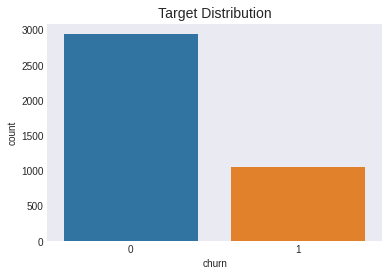

In [322]:
sns.countplot(train[TARGET_COL])
plt.title("Target Distribution", fontsize=14)

The graph shows us that there is class imbalance.

There are two types of features that we have:

1. Categorical
2. Numerical  
Also our target is Binary

For each feature type we will be perform two types of analysis:

1. **Univariate**: Analyze 1 feature at a time

2. **Bivariate**: Analyze the relationship of that feature with target variable, i.e. 'churn'

## Categorical Features

In [331]:
cat_cols

['gender',
 'seniorCitizen',
 'partner',
 'dependents',
 'phoneService',
 'multipleLines',
 'internetService',
 'onlineSecurity',
 'onlineBackup',
 'deviceProtection',
 'techSupport',
 'streamingTV',
 'streamingMovies',
 'contract',
 'paperlessBilling',
 'paymentMethod']

### Univariate Analysis

#### Pie Charts
Pie Charts can be useful in seeing the proportion of samples, that fall into each category of a categorical variable. For each of the categorical variables we will make a pie chart.**bold text**

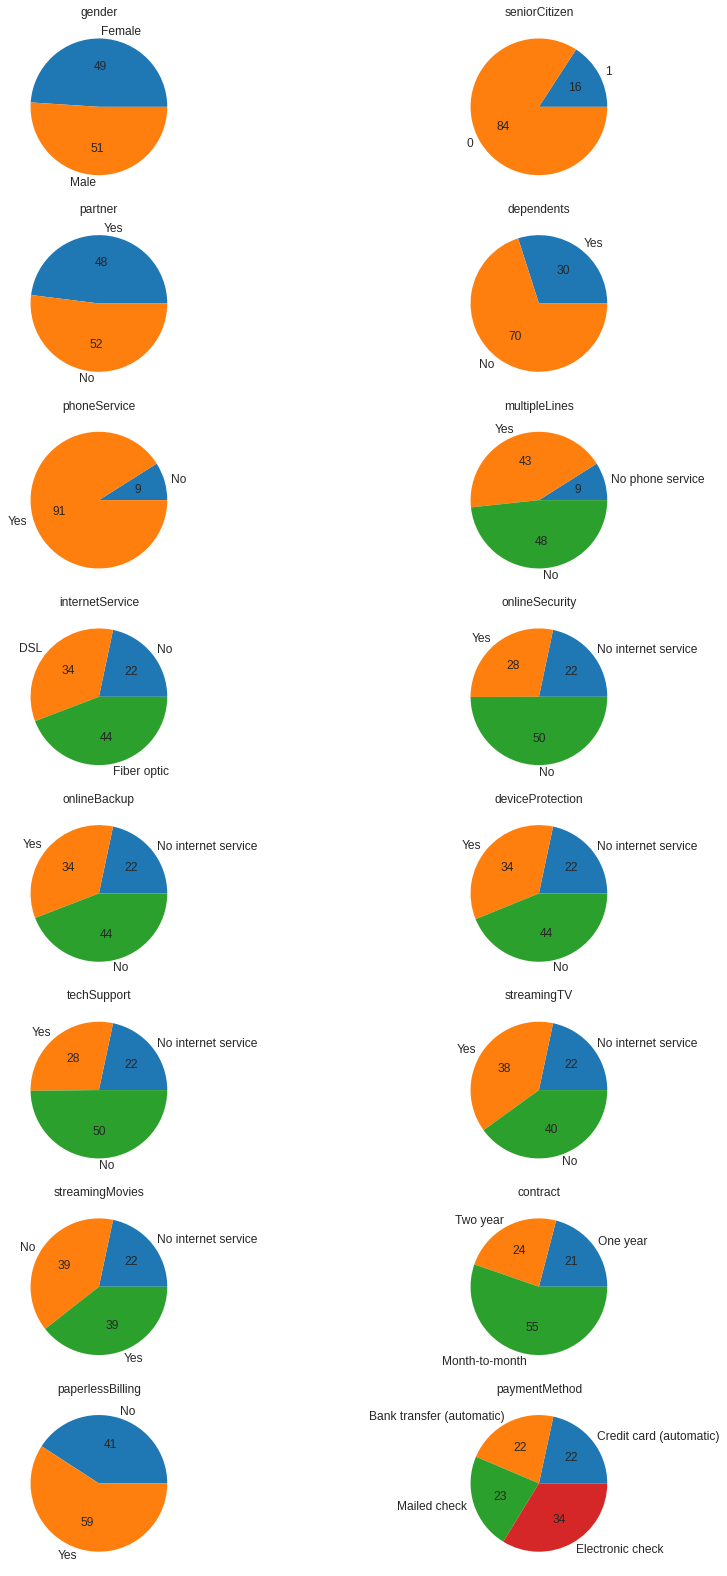

In [339]:
fig, axes = plt.subplots(8, 2, figsize=(14, 22))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    train[c].value_counts()[::-1].plot(kind = 'pie', ax=axes[i], title=c, autopct='%.0f', fontsize=12)
    axes[i].set_ylabel('')
    
plt.tight_layout()

Conclusions from Pie Chart Variable Proportions:
- Most of the variables exhibit balanced proportions.
- Only the variables `seniorCitizens`, `dependents` and `phoneService` have imbalanced proportions.

#### Count Plots
Another way of looking at the counts of each of the categories is countplots. These are similar to barplots with the width of the bars representing the count of the category in the variable

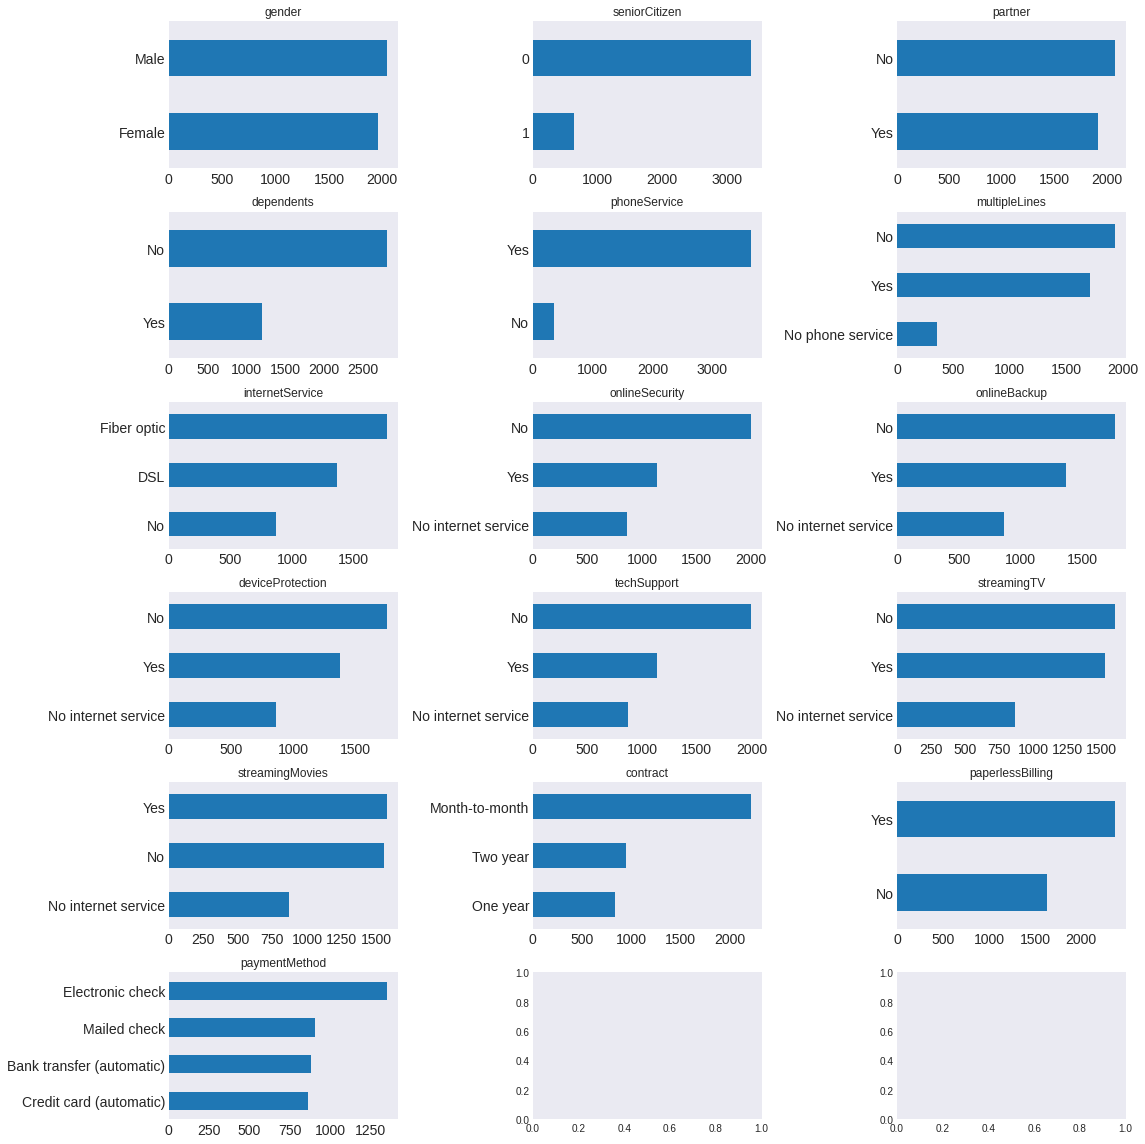

In [344]:
fig, axes = plt.subplots(6, 3, figsize=(16, 16))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

### Bivariate Analysis

Analysing Categorical Variable relationships with Target

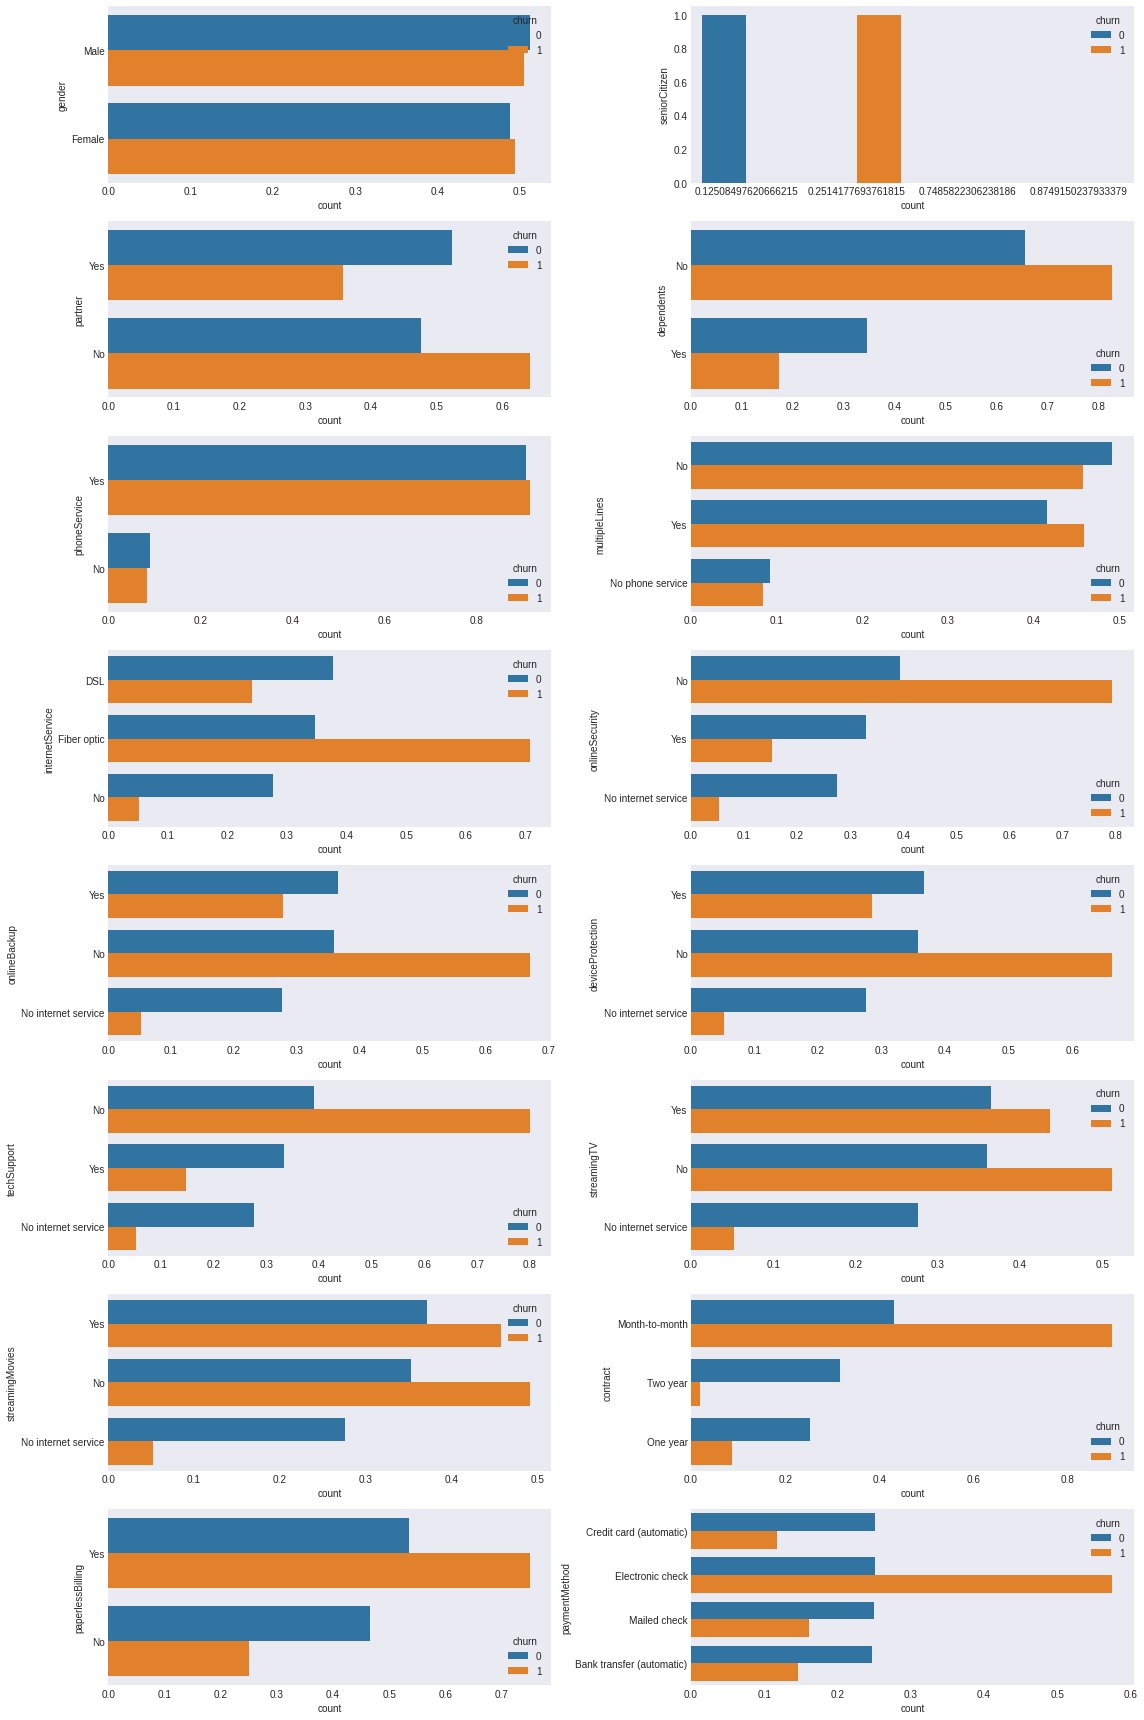

In [349]:
fig, axes = plt.subplots(8, 2, figsize=(16, 24))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    fltr = train[TARGET_COL] == 0
    vc_a = train[fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_b = train[~fltr][c].value_counts(normalize=True).reset_index().rename({'index' : c, c: 'count'}, axis=1)

    vc_a[TARGET_COL] = 0
    vc_b[TARGET_COL] = 1

    df = pd.concat([vc_a, vc_b]).reset_index(drop = True)

    _ = sns.barplot(y = c, x = 'count', data =df , hue=TARGET_COL, ax=axes[i])
    
_ = plt.tight_layout()

Important conclusions from Bivariate Analysis:  
As this is a plot of counts, the variables having imbalance in their categories is reflected over here.

1. `gender` - Negligible difference in churn.
2. `seniorCitizen` - Negligible difference in churn.
3. `partner` - People with partner are more likely to not leave company as compared to people without partner.
4. `dependents` - People without dependents are more likely to leave company as compared to people with dependents.
5. `phoneService` - Negligible difference to churn.
6. `multipleLines` - People without multipleLines are more likely to stay as compared to people with multipleLines.
7. `internetService` - People with DSL or No Internet Service are more likely to stay as compared to people with Fibre Optic.
8. `onlineSecurity` - People without online security are more likely to leave.
9. `onlineBackup` - People without online backup are more likely to leave.
10. `deviceProtection` - People without device protection are more likely to leave.
11. `techSupport` - People without Tech Support are more likely to leave.
12. `streamingTV` - People who are streaming and not streaming TV are more likely to leave as compared to people with no internet service.
13. `streamingMovies` - People who are streaming and not streaming movies are more likely to leave as compared to people with no internet service.
14. `contract` - People with Month-to-Month contract are more likely to leave as compared to people with One or Two year contracts.
15. `paperlessBilling` - People with paperlessBilling are more likely to leave as compared to people without paperlessBilling.
16. `paymentMethod` - People with Electronic check are more likely to leave as compared to people with Credit card, Mailed check or Bank transfer.


## Numerical Features

### Univariate Analysis

#### Box Plots
Boxplot can be used to see the spread of the numerical variables and identify outliers.

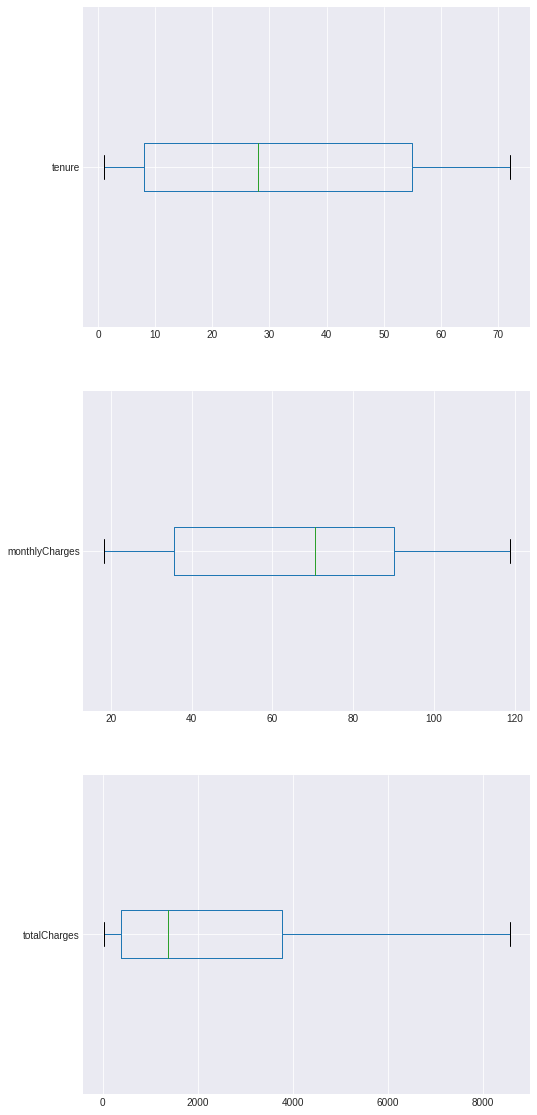

In [364]:
fig, axes = plt.subplots(3, 1, figsize=(8, 20))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

Conclusions from Box Plot:
- There is absence of outliers in the Numerical Columns
- `tenure` and `totalCharges` are right skewed and `monthlyCharges` is left skewed.

#### Density Plots
A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.

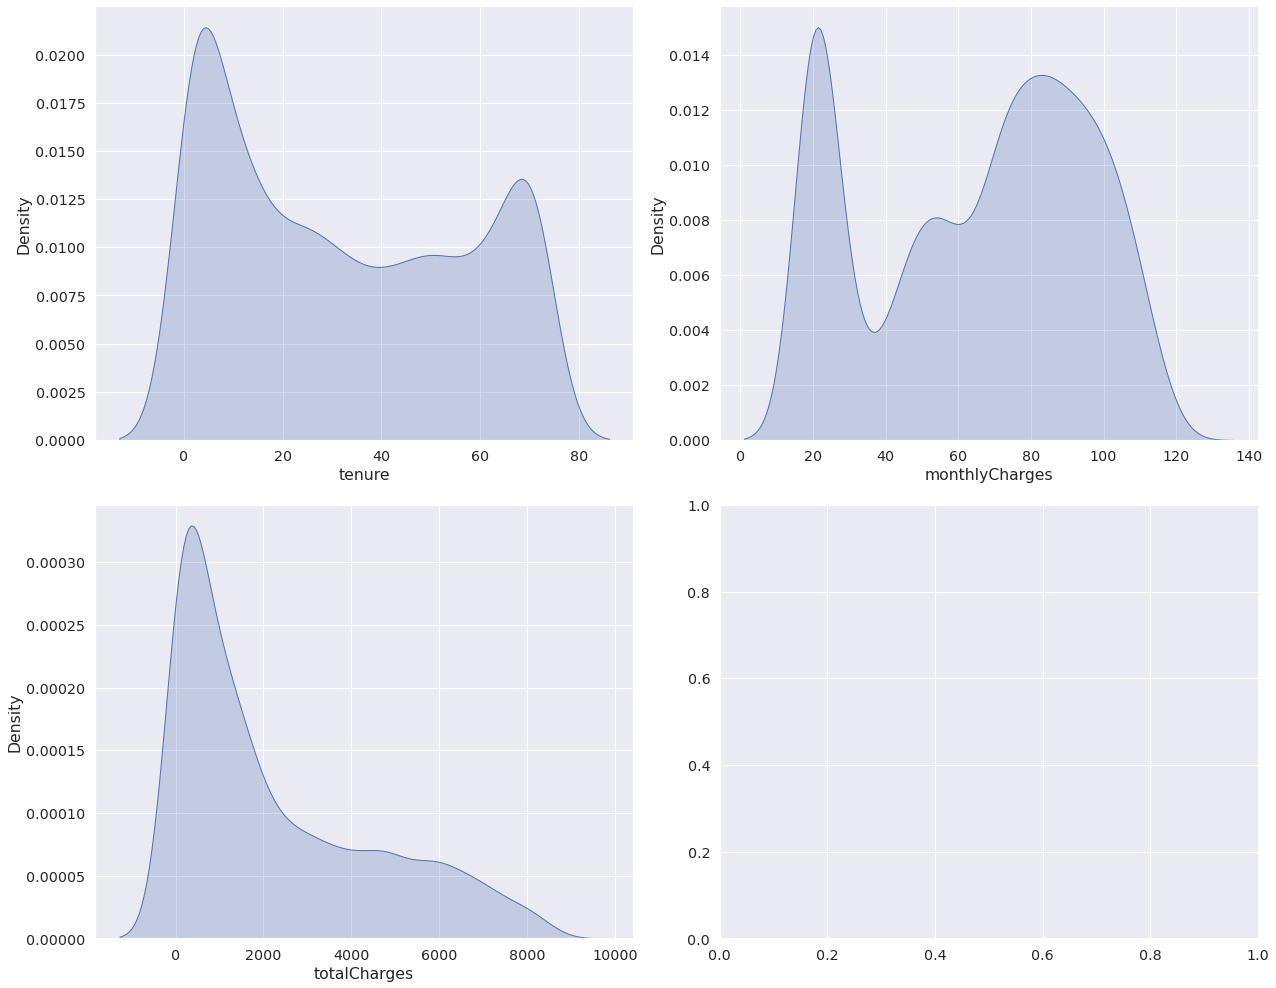

In [365]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

Conclusions from Density Plot:
- `tenure` has the highest density in the range of 0-10.
- `monthlyCharges` desnsity drops aggeresively after 20 and starts to rise again gradually around 40.
- `totalCharges` increases sharply till about 700 and then drops gradually.

### Bivariate Analysis

#### KDE Plots

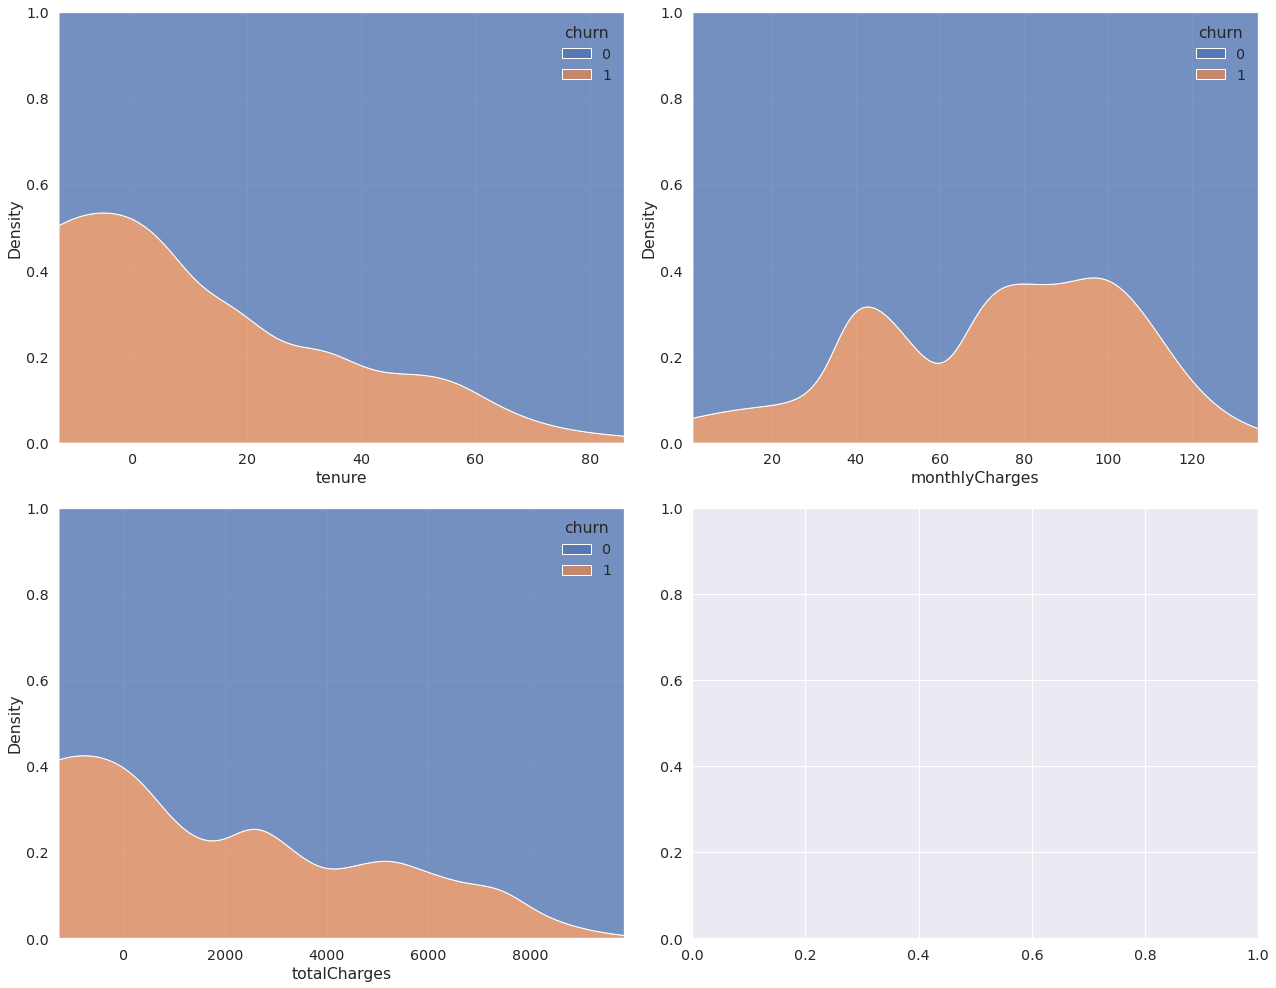

In [366]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, hue=TARGET_COL, multiple='fill', ax=axes[i])
plt.tight_layout()

#### Horizontal Bar Plots
For each numerical Variable. We will plot the median of the numerical variable for:

1. When churn == 0
2. when churn == 1

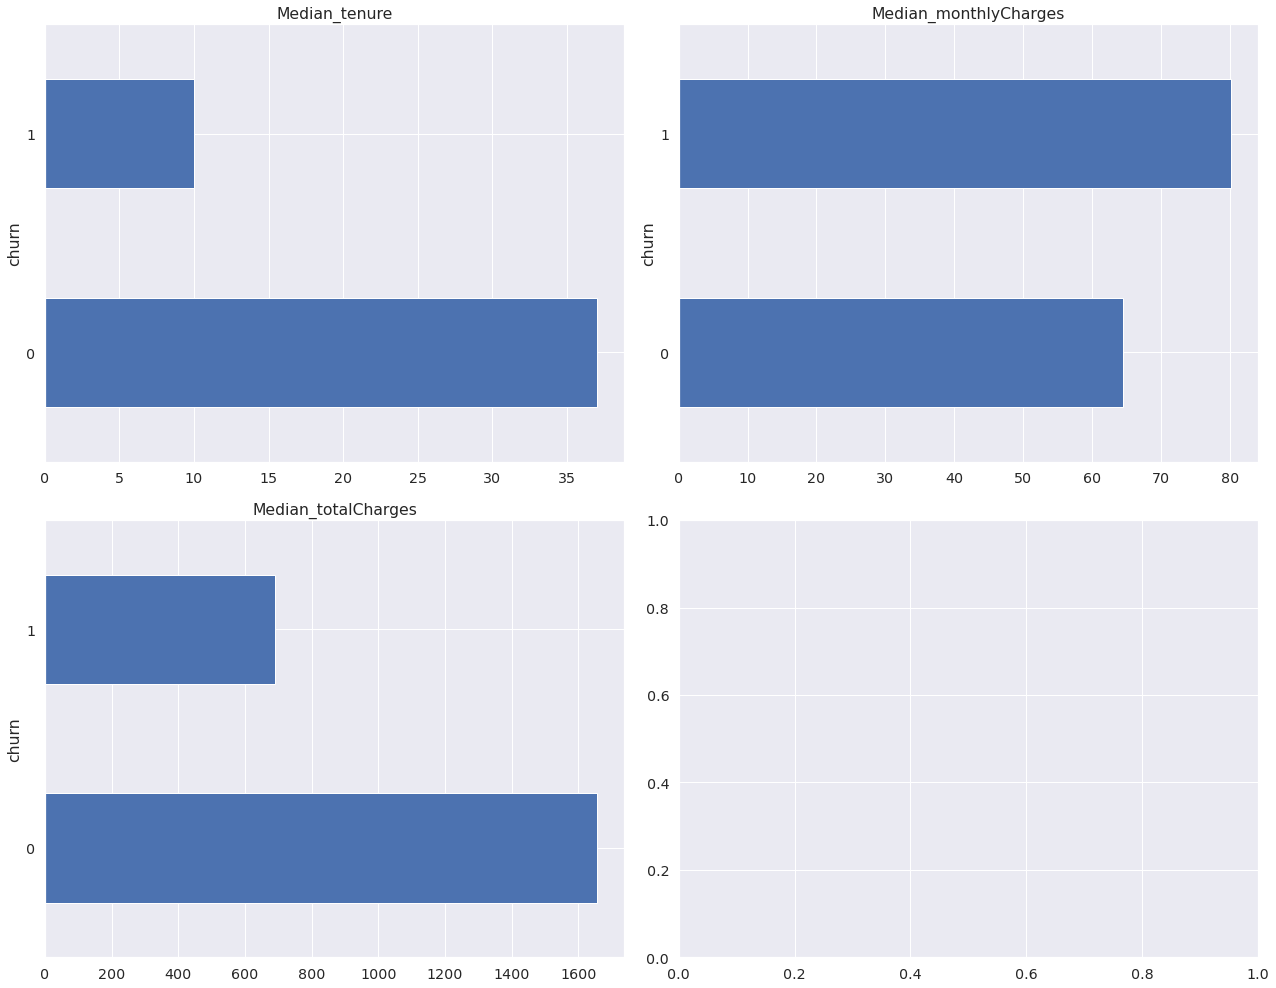

In [367]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = train.groupby(TARGET_COL)[c].median().plot(kind = 'barh', title=f'Median_{c}', ax=axes[i])
plt.tight_layout()

Conclusions from Horizontal Median Bar Plots:
- `tenure` and `totalCharges` heavily affect the customer churn.
- `monthlyCharges` also affects the customer churn but not as much as the other two numerical variables.

#### Correlation Heatmap

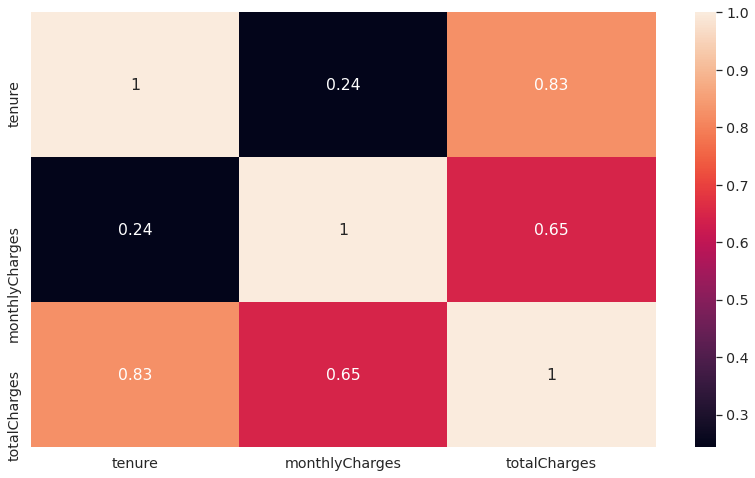

In [370]:
plt.figure(figsize=(14, 8))
sns.heatmap(train[num_cols].corr(), annot=True)

Conclusions from Heatmap:
- `tenure` and `totalCharges` exhibit very strong correlation.
- `tenure` and `monthlyCharges` exhibit weak correlation.
- `totalCharges` and `monthlyCharges` exhibit good correlation.

# Machine Learning Models

## Baseline Models

Now that we have a good understanding of the dataset, let us begin with some baseline models.

### Majority Baseline
Predict all instances as majority. In our case we shall predict that `churn` = 0 for all samples.

In [374]:
train.churn.value_counts()

0    2942
1    1058
Name: churn, dtype: int64

In [380]:
# Define Target
target = train[TARGET_COL]

# Calculate Predictions
preds = np.zeros(len(train))

# Evaluate Model
accuracy = accuracy_score(target, preds)
f1 = f1_score(target, preds)

print(f'Accuracy score is: {accuracy*100}%')
print(f'F1 score is: {f1}')

Accuracy score is: 73.55000000000001%
F1 score is: 0.0


We get an accuracy of 73.5% which may seem okay but f1_score is 0, which means we definitely need a better model.

### Rule Based Baseline
We saw in the Median Plots that the Numerical features were affecting the churn significantly. So we will make a rule function based on the median plots.

In [383]:
def rule_based_clf(df):
  preds = np.zeros(len(df))
  rule = (df['tenure'] < 10) | (df['totalCharges'] < 700)
  preds[rule] = 1
  return preds

In [384]:
preds = rule_based_clf(train)

# Evaluate Model
accuracy = accuracy_score(target, preds)
f1 = f1_score(target, preds)

print(f'Accuracy score is: {accuracy*100}%')
print(f'F1 score is: {f1}')

Accuracy score is: 65.675%
F1 score is: 0.44525252525252523


As we see that our accuracy dropped to 65.6% but we have got a better f1 score of 0.44. This indicates that our hypothesis about numerical columns affectinf churn is correct!

## Classification Models

There are a lot of classification models that can be used, many of them such as Gradient Boosting Models and Neural Networks. However, for the purpose of creating a baseline classification model, we will make the following:

1. Decision Tree
2. Logistic Regression

First we shall prepare our dataset in a way that it can be passed to the model. As we have alrealy done the preprocessing part in the initial sections of the notebooks, we just need to separate the train and test datasets and pass it to our model.

In [529]:
# One Hot Encode Categorical Features
df = pd.get_dummies(df, columns = cat_cols)

In [498]:
# Obtain Train and Test data and define the features

train, test, features = processed_data(df)
features = [feature for feature in features if feature not in cat_cols]

In [500]:
# Split train and validation data
trn, val = train_test_split(train, test_size=0.2, random_state = 1, stratify = train[TARGET_COL])

# Input to our model will be the features
X_trn, X_val = trn[features], val[features]

# Output of our model will be the TARGET_COL
y_trn, y_val = trn[TARGET_COL], val[TARGET_COL]

# Features for the test data that we will be predicting
X_test = test[features]

In [501]:
# Standardize the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
_ = scaler.fit(X_trn)

X_trn = scaler.transform(X_trn)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [502]:
def run_model(clf):
  """
  Function to fit the classifier, generate predictions and calculate f1_score.
  params: clf - The classifier which needs to be implemented
  """

  # Define Model
  clf = clf

  # Fit Model
  clf.fit(X_trn, y_trn)

  # Obtain Predictions
  preds_val = clf.predict(X_val)

  # Evaluate Model
  metric = f1_score(y_val, preds_val)
  print(f"f1 score: {metric}")

### Decision Tree

A Decision Tree is a flowchart like structure, where each node represents a decision, each branch represents an outcome of the decision, and each terminal node provides a prediction / label.

In [503]:
run_model(DecisionTreeClassifier(random_state = 42))

f1 score: 0.4622222222222222


Decision Tree gave us a slight improvement in `f1 score` from **0.44** to **0.46**

### Logistic Regression
Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

In [504]:
run_model(LogisticRegression(random_state = 42))

f1 score: 0.5829145728643216


Using Logistic Regression Model, our `f1 score` improved from **0.46** to **0.58**.

## **Gradient Boosting**

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

Most Popular Variants of GradientBoosting
1. XGBoost
2. Catboost
3. LightGBM

To implement Gradient Boosting, we will create a simple function. This function will use Stratified K-Fold Technique to generate training and validation sets. StratifiedKFold ensures that each of the splits have same proportion of examples of each class.

In [505]:
def run_gradient_boosting(clf, fit_params, train, test, features):
  
  N_SPLITS = 5
  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  folds = StratifiedKFold(n_splits = N_SPLITS)

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, train[TARGET_COL])):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict_proba(X_val)[:, 1]
    preds_test = clf.predict_proba(X_test)[:, 1]

    fold_score = f1_score(y_val, preds_val.round())
    print(f'\nF1 score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = f1_score(target, oofs.round())
  print(f'\n\nF1 score for oofs is {oofs_score}')

  return oofs, preds

Since here we are working with a classification problem with `f1 score` as a metric, we shall be able to optimize the threshold.

In [506]:
def get_optimal_f1_thresh(target, oofs):
  thresholds = np.arange(0, 100)/100
  thresh_scores = []
  for thresh in thresholds:
    oofs_rounded = (lgb_oofs > thresh) * 1
    thresh_score = f1_score(target, oofs_rounded)
    thresh_scores.append(thresh_score)
  
  all_thresholds_and_scores = pd.Series(index = thresholds, data = thresh_scores)
  all_thresholds_and_scores.plot(figsize=(10, 6), fontsize=14)
  
  plt.xlabel('Threshold', fontsize=14)
  plt.ylabel('F1 Score', fontsize=14)

  return all_thresholds_and_scores.sort_values(ascending=False).index.values[0]

In [507]:
# Define the Target
target = train[TARGET_COL]

### **XGBoost**

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.


------------- Fold 1 -------------
[0]	validation_0-error:0.22375
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.18875
Stopping. Best iteration:
[6]	validation_0-error:0.18375


F1 score for validation set is 0.6201550387596899

------------- Fold 2 -------------
[0]	validation_0-error:0.2
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.1875
Stopping. Best iteration:
[15]	validation_0-error:0.17


F1 score for validation set is 0.6476683937823834

------------- Fold 3 -------------
[0]	validation_0-error:0.21375
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validation_0-error:0.20625
[400]	validation_0-error:0.21
Stopping. Best iteration:
[233]	validation_0-error:0.20125


F1 score for validation set is 0.5839793281653747

------------- Fold 4 -------------
[0]	validation_0-error:0.215
Will train until validation_0-error hasn't improved in 200 rounds.
[200]	validatio

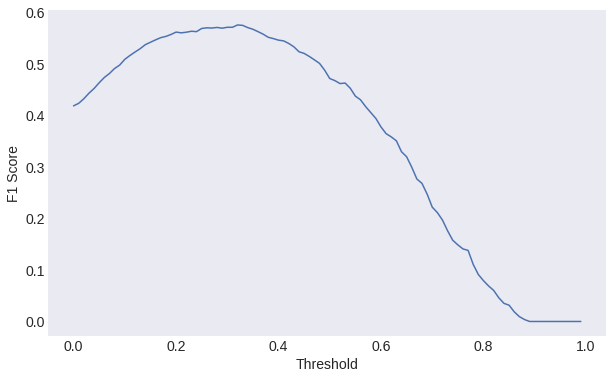

In [509]:
clf = XGBClassifier(n_estimators = 1000,
                    max_depth = 6,
                    learning_rate = 0.05,
                    colsample_bytree = 0.5,
                    random_state=1452,
                    )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

xgb_oofs, xgb_preds = run_gradient_boosting(clf, fit_params, train, test, features)

optimal_thresh = get_optimal_f1_thresh(target, xgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (xgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

XGBoost is not giving us improved results, `f1 score` of **0.50**

### **CatBoost**
CatBoost is a high-performance open source library for gradient boosting on decision trees.

Features

* Great quality without parameter tuning: Reduce time spent on parameter tuning, because CatBoost provides great results with default parameters

* Categorical features support: Improve your training results with CatBoost that allows you to use non-numeric factors, instead of having to pre-process your data or spend time and effort turning it to numbers.

* Fast and scalable GPU version: Train your model on a fast implementation of gradient-boosting algorithm for GPU. Use a multi-card configuration for large datasets.

* Improved accuracy: Reduce overfitting when constructing your models with a novel gradient-boosting scheme.

* Fast prediction: Apply your trained model quickly and efficiently even to latency-critical tasks using CatBoost's model applier


------------- Fold 1 -------------
0:	learn: 0.6864012	test: 0.6864362	best: 0.6864362 (0)	total: 4.06ms	remaining: 12.2s
200:	learn: 0.3892584	test: 0.4188355	best: 0.4188355 (200)	total: 842ms	remaining: 11.7s
400:	learn: 0.3602439	test: 0.4113035	best: 0.4111365 (394)	total: 1.69s	remaining: 11s
600:	learn: 0.3412044	test: 0.4124336	best: 0.4111281 (420)	total: 2.52s	remaining: 10.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4111281354
bestIteration = 420

Shrink model to first 421 iterations.

F1 score for validation set is 0.6010362694300518

------------- Fold 2 -------------
0:	learn: 0.6863905	test: 0.6864860	best: 0.6864860 (0)	total: 4.14ms	remaining: 12.4s
200:	learn: 0.3984228	test: 0.3991226	best: 0.3991226 (200)	total: 829ms	remaining: 11.5s
400:	learn: 0.3704329	test: 0.3839757	best: 0.3839757 (400)	total: 1.64s	remaining: 10.6s
600:	learn: 0.3508401	test: 0.3816749	best: 0.3816227 (598)	total: 2.47s	remaining: 9.85s
800:	learn: 0.3334033	test

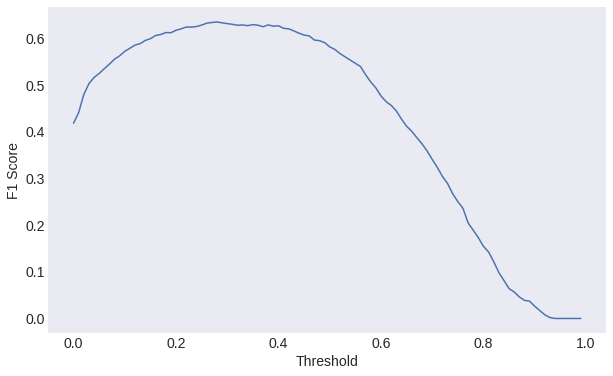

In [511]:
clf = CatBoostClassifier(n_estimators = 3000,
                       learning_rate = 0.01,
                       rsm = 0.4, ## Analogous to colsample_bytree
                       random_state=2054,
                       )

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

cb_oofs, cb_preds = run_gradient_boosting(clf, fit_params, train, test, features)

optimal_thresh = get_optimal_f1_thresh(target, cb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (cb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

CatBoost is giving us the better results, i.e., `f1 score` of **0.633**

### **LightGBM**
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.

* Lower memory usage.

* Better accuracy.

* Support of parallel and GPU learning.

* Capable of handling large-scale data.


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.416877
[400]	valid_0's binary_logloss: 0.410531
Early stopping, best iteration is:
[341]	valid_0's binary_logloss: 0.409356

F1 score for validation set is 0.6057441253263708

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.395349
[400]	valid_0's binary_logloss: 0.38247
[600]	valid_0's binary_logloss: 0.387769
Early stopping, best iteration is:
[434]	valid_0's binary_logloss: 0.382004

F1 score for validation set is 0.6037735849056605

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.417198
[400]	valid_0's binary_logloss: 0.412724
[600]	valid_0's binary_logloss: 0.418085
Early stopping, best iteration is:
[438]	valid_0's binary_logloss: 0.412554

F1 score for validation set is 0.566326530612

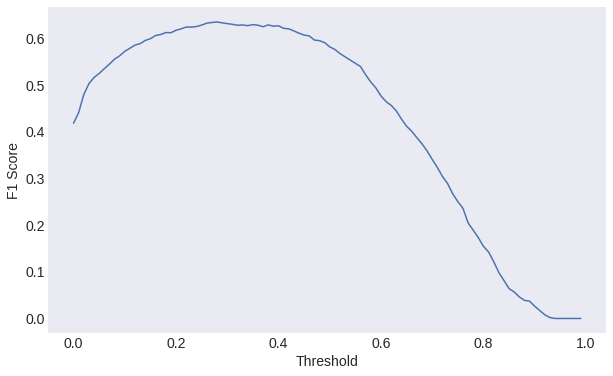

In [510]:
clf = LGBMClassifier(n_estimators = 5000,
                     learning_rate = 0.01,
                     colsample_bytree = 0.65,
                     random_state = 42)

fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train, test, features)

optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
print(f'Optimal threhold is {optimal_thresh}')
optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
print(f'Optimized F1 is {optimized_f1}')

With just the optimization of the threshold, we have achieved a good imporvement and have reached `f1 score` of **0.635**

To improve our model furthur, we have to perform Feature Engineering.

# Feature Engineering

Since LightGBM is giving us the best results, we shall move ahead with it. We make a simple function that will run the model instead of writing everything everytime.

In [530]:
def run_lightGBM():
  """
  Function to run LightGBM Classifier and find optimized threshold
  """
  clf = LGBMClassifier(n_estimators = 5000,
                     learning_rate = 0.01,
                     colsample_bytree = 0.65,
                     random_state = 42)

  fit_params = {'verbose': 200, 'early_stopping_rounds': 200}

  lgb_oofs, lgb_preds = run_gradient_boosting(clf, fit_params, train, test, features)

  optimal_thresh = get_optimal_f1_thresh(target, lgb_oofs)
  print(f'Optimal threhold is {optimal_thresh}')
  optimized_f1 = f1_score(target, (lgb_oofs > optimal_thresh) * 1)
  print(f'Optimized F1 is {optimized_f1}')

### **Frequency Features**

We will create a frequency mapper, and will map the frequency as a new feature.

In [531]:
# Define columns which are eligible to be used as frequency columns
freq_cols = [c for c in df.columns if (df[c].nunique() > 2) and (df[c].nunique() < 50)]

In [532]:
def get_frequency_features(df, cols):
  """
  Function to obtain the new features by mapping input features with their value counts.
  
  params: df(Pandas Dataframe) - Dataframe containing features
          cols(list)           - List of Frequency Columns

  returns: df(Pandas Dataframe) - Dataframe with New Features
  """

  df[[c + '_freq' for c in cols]] = df[cols].apply(lambda x: x.map(x.value_counts()))
  
  return df

In [533]:
df = get_frequency_features(df, freq_cols)
train, test, features = processed_data(df)


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.416606
[400]	valid_0's binary_logloss: 0.411274
Early stopping, best iteration is:
[311]	valid_0's binary_logloss: 0.409584

F1 score for validation set is 0.6036745406824147

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.396885
[400]	valid_0's binary_logloss: 0.382103
[600]	valid_0's binary_logloss: 0.384359
Early stopping, best iteration is:
[461]	valid_0's binary_logloss: 0.381473

F1 score for validation set is 0.6219839142091153

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.416071
[400]	valid_0's binary_logloss: 0.4126
Early stopping, best iteration is:
[328]	valid_0's binary_logloss: 0.41218

F1 score for validation set is 0.5736434108527132

------------- Fold 4 -------------
Tr

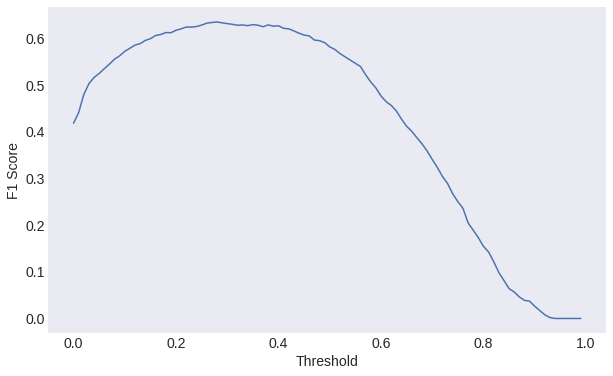

In [534]:
run_lightGBM()

The frequency features were not that helpful.

### **Numerical Features**

I will add some features by combining existing numerical features.

In [535]:
df['monthlyCharges_by_tenure'] = df['monthlyCharges']/df['tenure']
df['totalCharges_by_tenure'] = df['totalCharges']/df['tenure']

df['totalCharges_by_monthlyCharges'] = df['totalCharges']/df['monthlyCharges']


------------- Fold 1 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.418782
[400]	valid_0's binary_logloss: 0.413658
Early stopping, best iteration is:
[282]	valid_0's binary_logloss: 0.413084

F1 score for validation set is 0.5894736842105264

------------- Fold 2 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.395268
[400]	valid_0's binary_logloss: 0.382309
[600]	valid_0's binary_logloss: 0.386811
Early stopping, best iteration is:
[415]	valid_0's binary_logloss: 0.382245

F1 score for validation set is 0.6223404255319148

------------- Fold 3 -------------
Training until validation scores don't improve for 200 rounds.
[200]	valid_0's binary_logloss: 0.417176
[400]	valid_0's binary_logloss: 0.409006
[600]	valid_0's binary_logloss: 0.41599
Early stopping, best iteration is:
[410]	valid_0's binary_logloss: 0.408867

F1 score for validation set is 0.581632653061

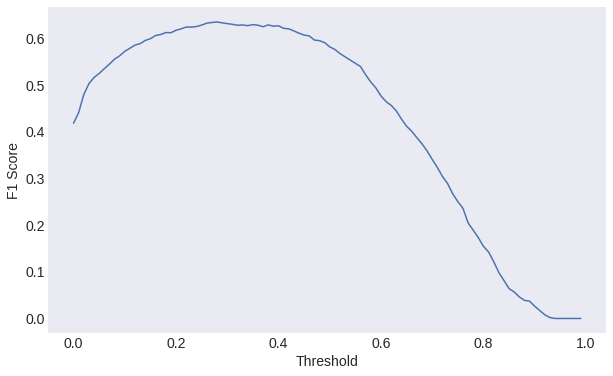

In [536]:
train, test, features = processed_data(df)
run_lightGBM()

# Final Report

## Offers to be made by Company

Based on the results from the Data Visualization and performance of the model, following factors should be considered while making offers to customers to make them stay with the company:

1. Provide additional incentives to people without partners and dependents as they are more likely to leave the company.
2. The company should definitely offer features like Online Security, Online Backup, Device Protection and Tech Support to be able to retain its customers.
3. People should be encouraged for longer Tenures (i.e., One or Two Years) instead of month-to-month plans.

## Model Details


The LightGBM Classifier gave us the best performance with the following set of parameters:  
`n_estimators` = 5000  
`learning_rate` = 0.01  
`colsample_bytree` = 0.65  
`random_state` = 42